In [1]:
# basic data analysis dan visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="Paired")
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

# statistic
from scipy.stats import normaltest,kruskal

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler
import category_encoders as ce

# model regression
#pip install catboost
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor

# model selection & hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, KFold

# metric regression
from sklearn.metrics import mean_absolute_error

# hyperparameter tuning
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

# Model Interpretation
import shap

import warnings
warnings.filterwarnings('ignore')

import time
shap.initjs()

**Get data from file 01 EDA - Final Preparation**

In [2]:
%store -r df
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,4
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,5
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,5
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,4
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,2
...,...,...,...,...,...,...,...,...,...,...,...
108535,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,vw,9
108536,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,vw,13
108537,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,vw,12
108538,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,vw,15


# Preprocessing

## Handling Missing Value

### Tax

In [3]:
df['tax'].isna().sum()

9353

In [4]:
df[df['tax']==0]['tax'].value_counts()

0.0    6294
Name: tax, dtype: int64

* Berdasarkan data di atas, didapatkan informasi bahwa terdapat mobil yg memiliki nilai `tax` sebesar 0, hal ini memungkinkan. Dilansir dari https://www.moneyhelper.org.uk/en/everyday-money/buying-and-running-a-car/car-tax-bands-explained, mobil dengan tingkat emisi di bawah 100(g/km) akan dikenakan bebas pajak. 
* Data `tax = NaN` akan diasumsikan sebagai _Missing Value_ dan akan dibuatkan kolom baru untuk menandai data tersebut merupakan _Missing Value_ atau bukan.

In [5]:
df['tax']=df['tax'].fillna(-1)

In [6]:
df['tax_is_missing']=np.where(df['tax']==-1,1,0)

In [7]:
df['tax'].isna().sum()

0

### MPG

In [8]:
df['mpg'].isna().sum()

9353

In [9]:
df[df['mpg']==0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age,tax_is_missing


Berdasarkan data di atas, didapatkan informasi bahwa terdapat mobil dengan data `mpg = NaN`. Hal ini tidak mungkin karena setiap kendaraan pasti akan memiliki nilai mpg sepanjang penggunaan mobil. Oleh karena itu akan dibuatkan kolom baru untuk menandai data tersebut merupakan _Missing Value_ atau bukan.

In [10]:
df['mpg']=df['mpg'].fillna(0)

In [11]:
df['mpg_is_missing']=np.where(df['mpg']==0,1,0)

In [12]:
df['mpg'].isna().sum()

0

### engineSize

In [13]:
df['engineSize'].isna().sum()

0

In [14]:
df[df['engineSize']==0]['engineSize'].value_counts()

0.0    286
Name: engineSize, dtype: int64

Berdasarkan data di atas, didapatkan informasi bahwa terdapat mobil yg memiliki nilai `engineSize` sebesar 0. Hal ini tidak mungkin terjadi karena tidak mungkin terdapat kendaraan tanpa memiliki kapasitas mesin, kendaraan dengan jenis bahan electric pun menggunakan baterai yang memiliki suatu kapasitas tersendiri. Oleh karena itu, data tersebut akan diasumsikan sebagai _Missing Value_ dan akan dibuatkan kolom baru untuk menandai data tersebut merupakan _Missing Value_ atau bukan.

In [15]:
df['engineSize_is_missing']=np.where(df['engineSize']==0,1,0)

## Casting Data Type

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   model                  108540 non-null  object 
 1   year                   108540 non-null  int64  
 2   price                  108540 non-null  int64  
 3   transmission           108540 non-null  object 
 4   mileage                108540 non-null  int64  
 5   fuelType               108540 non-null  object 
 6   tax                    108540 non-null  float64
 7   mpg                    108540 non-null  float64
 8   engineSize             108540 non-null  float64
 9   brand                  108540 non-null  object 
 10  age                    108540 non-null  int64  
 11  tax_is_missing         108540 non-null  int64  
 12  mpg_is_missing         108540 non-null  int64  
 13  engineSize_is_missing  108540 non-null  int64  
dtypes: float64(3), int64(7), object(4)
m

Akan dilakukan perubahan _datatype_ untuk _categorical features_, antara lain fitur `model`, `transmission`, `fuelType`, dan `brand` menjadi tipe data _category_. Hal ini dilakukan untuk menyesuaikan kebutuhan data pada CatBoost dan SHAP.

In [17]:
df['model']=df['model'].astype('category')
df['transmission']=df['transmission'].astype('category')
df['fuelType']=df['fuelType'].astype('category')
df['brand']=df['brand'].astype('category')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   model                  108540 non-null  category
 1   year                   108540 non-null  int64   
 2   price                  108540 non-null  int64   
 3   transmission           108540 non-null  category
 4   mileage                108540 non-null  int64   
 5   fuelType               108540 non-null  category
 6   tax                    108540 non-null  float64 
 7   mpg                    108540 non-null  float64 
 8   engineSize             108540 non-null  float64 
 9   brand                  108540 non-null  category
 10  age                    108540 non-null  int64   
 11  tax_is_missing         108540 non-null  int64   
 12  mpg_is_missing         108540 non-null  int64   
 13  engineSize_is_missing  108540 non-null  int64   
dtypes: category(4), floa

## Handling Anomaly Data

Berdasarkan proses Identifying Anomaly Data, didapatkan data `year` = 2060. Data ini akan didrop.

In [19]:
df[df['year'] == 2060]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age,tax_is_missing,mpg_is_missing,engineSize_is_missing
48528,Fiesta,2060,6495,Automatic,54807,Petrol,205.0,42.8,1.4,ford,-39,0,0,0


In [20]:
df.drop(df[df['year'] == 2060].index, inplace = True)

## Remove Duplicated Data

Berdasarkan proses Identifying _Duplicated Data_, didapatkan data yang terindikasi duplikat sebanyak 2273 data. Data ini akan didrop.

In [21]:
df=df.drop_duplicates(keep='first')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand,age,tax_is_missing,mpg_is_missing,engineSize_is_missing
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi,4,0,0,0
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi,5,0,0,0
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi,5,0,0,0
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi,4,0,0,0
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi,2,0,0,0


## Feature Engineering

Encoding _categorical data_

In [22]:
transformer = ColumnTransformer([
    ('one hot encoding', OneHotEncoder(drop='first'), ['transmission', 'fuelType', 'brand']),
    ('binary encoding', ce.BinaryEncoder(),['model']),
], remainder='passthrough')

# Methodology

## Data Splitting 

In [23]:
x = df.drop(columns=['year', 'price'])
y = df['price']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=2020
)

## Model Benchmark

Pada project ini akan fokus menggunakan model **CatBoost**, tetapi pada tahap ini akan dilakukan _benchmarking_ menggunakan model-model regresi lainnya.

In [25]:
modelLinReg = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()
modelTree = DecisionTreeRegressor(random_state=2020, criterion='mae')
modelKNN = KNeighborsRegressor()
modelCB = CatBoostRegressor(random_state=2020, loss_function='MAE', silent=True)

In [26]:
models = [
    modelLinReg, 
    modelRidge,
    modelLasso,
    modelTree,
    modelKNN,
    modelCB,
]

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

mae_scores = []
mae_std = []
for i in models:
    scores = []
    
    for train_index, val_index in kf.split(x_train):
    #     print("TRAIN:", train_index, "VAL:", val_index)
        x1_train, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
        y1_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        estimator = Pipeline([
            ('preprocess', transformer),
            ('model', i)
        ])
        
        estimator.fit(x1_train, y1_train)
        scores.append(mean_absolute_error(y_val, estimator.predict(x_val)))

    mae_scores.append(np.mean(scores))
    mae_std.append(np.std(scores))

    

In [28]:
modelBenchmark=pd.DataFrame({
    'model': ['linreg', 'ridge', 'lasso', 'tree', 'knn', 'cb'],
    'mae_score_mean': mae_scores,
    'mae_score_std': mae_std,
})
modelBenchmark

,model,mae_score_mean,mae_score_std
0,linreg,2881.961708,24.006749
1,ridge,2881.786394,23.989191
2,lasso,2880.458221,23.577161
3,tree,1552.484552,23.133451
4,knn,5276.961121,35.703659
5,cb,1446.918816,21.382691


> Berdasarkan hasil _benchmarking_ di atas didapatkan bahwa model `CatBoost` memiliki nilai rata-rata MAE yang paling rendah yaitu **1446.918816** yang berarti model tersebut memiliki performa paling baik, serta nilai standard deviasi yang baik senilai **21.382691**.

## Model Improvement

### Categorical Features

Pada tahap ini akan dilakukan tuning terhadap `categorical features`, antara lain `model`, `transmission`, `fuelType`, dan `brand`. Pada tahap `model benchmark` fitur-fitur tersebut _encoding_ dilakukan secara manual, sedangkan pada tahap ini akandilakukan _encoding_ secara otomatis berdasarkan parameter yg disediakan dari model CatBoost.

In [29]:
cat_features=['model','transmission','fuelType','brand']

In [30]:
modelCB_CF = CatBoostRegressor(random_state=2020, loss_function='MAE', silent=True, cat_features=cat_features)

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

mae_scores = []
mae_std = []
scores = []

for train_index, val_index in kf.split(x_train):
#     print("TRAIN:", train_index, "VAL:", val_index)
    x1_train, x_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y1_train, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    modelCB_CF.fit(x1_train, y1_train)
    scores.append(mean_absolute_error(y_val, modelCB_CF.predict(x_val)))

mae_scores.append(np.mean(scores))
mae_std.append(np.std(scores))

In [32]:
modelImprov_1=pd.DataFrame({
    'model': ['cb_cf'],
    'mae_score_mean': mae_scores,
    'mae_score_std': mae_std,
})
modelImprov_1

,model,mae_score_mean,mae_score_std
0,cb_cf,1416.571264,17.119124


> Setelah dilakukan tuning terhadap `categorical features`, terdapat peningkatan performa sebesar **2.10%** yaitu _MAE Score_ dari **1446.918816** menjadi **1416.571264** serta peningkatan pada stabilitas model sebesar **19.94%** yaitu _STDev_ dari **21.382691** menjadi **17.119124**.

### Hyperparameter Tuning

Pada tahap ini akan dilakukan hyperparameter tuning dengan menggunakan _Hyperopt_ untuk mencari parameter terbaik yg akan digunakan pada model CatBoost.

In [33]:
# !pip install hyperopt
# !pip install colorama

In [34]:
N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [35]:
x2_train, x_val, y2_train, y_val = train_test_split(
    x_train,
    y_train,
    random_state=2020
)

In [36]:
def get_catboost_params(space):
    params=dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])

    return params

In [37]:
obj_call_count = 0
cur_best_mae = np.inf

In [38]:
def objective(space):
    global obj_call_count, cur_best_mae

    obj_call_count += 1

#     print('\nCatBoost objective call #{} cur_best_mae={:7.5f}'.format(obj_call_count,cur_best_mae) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    
#     print('Params: {}'.format(params_str) )

    model = CatBoostRegressor(learning_rate=params['learning_rate'],
                              depth=int(params['depth']),
                              loss_function='MAE',
                              eval_metric='MAE',
                              verbose=False,
                              random_state=2020
                             )
    
    model.fit(x2_train, y2_train, verbose=False, cat_features=cat_features)
    nb_trees = model.tree_count_

#     print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict(x_val)
    test_mae = mean_absolute_error(y_val, y_pred)

    if test_mae<cur_best_mae:
        cur_best_mae = test_mae
#         print('New Best MAE={}'.format(cur_best_mae))

    return{'loss':test_mae, 'status': STATUS_OK }

In [39]:
space = {
        'depth': hp.quniform('depth', 5, 9, 1), # (label, low, high, q)
        'learning_rate': hp.loguniform('learning_rate',  -5.0, -2) # (label, low, high)
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

# print('-'*50)
print('Best params:',best)
# print('\n\n')

100%|██████████| 60/60 [55:16<00:00, 55.28s/trial, best loss: 1182.58796915907]  
Best params: {'depth': 9.0, 'learning_rate': 0.1257381340409205}


In [40]:
print('Best Parameter:', best)

Best Parameter: {'depth': 9.0, 'learning_rate': 0.1257381340409205}


In [41]:
print('Best MAE Score:', cur_best_mae)

Best MAE Score: 1182.58796915907


> Setelah dilakukan `hyperparameter tuning`, terdapat peningkatan performa sebesar **16.52%** yaitu _MAE Score_ dari **1416.571** menjadi **1182.588**.

## Feature Importance

In [42]:
bestModelCB = CatBoostRegressor(learning_rate=best['learning_rate'], loss_function='MAE', max_depth=best['depth'], random_state=2020, silent=True, cat_features=cat_features)
bestModelCB.fit(x_train, y_train)

In [43]:
featureImportance = pd.DataFrame({'importance':bestModelCB.feature_importances_},index=bestModelCB.feature_names_)
featureImportance.sort_values(by='importance', ascending=False)

,importance
engineSize,28.441967
age,14.269524
brand,13.661444
mpg,13.362332
model,12.649377
mileage,8.371488
transmission,4.194118
fuelType,3.331549
tax,1.703960
engineSize_is_missing,0.014241


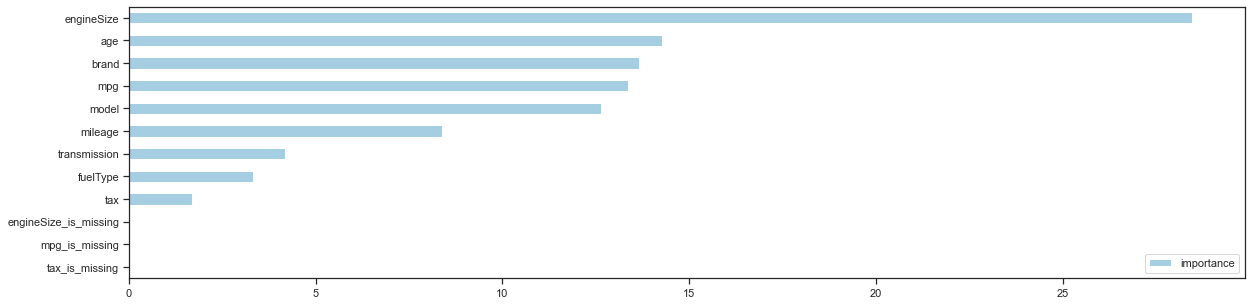

In [44]:
featureImportance.sort_values(by='importance').plot(kind='barh',figsize=(20,5))
plt.legend(loc=4)
plt.show()

> Berdasarkan data di atas, didapatkan informasi bahwa 3 fitur yg memiliki nilai _importance_ paling tinggi dalam menentukan target `(Price)` secara berturut-turut adalah fitur `engineSize` dengan nilai **28.44**, fitur `age` dengan nilai **14.27**  dan fitur `brand` dengan nilai **13.66**. 

> Fitur yang tidak signifikan dalam menentukan target `(Price)` adalah fitur `tax_is_missing` dan `mpg_is_missing` dengan nilai _improtance_ **0**.

## Model-based Testing

### Before Improvement

In [47]:
# Model CatBoost
modelCB_Before = CatBoostRegressor(random_state=2020, loss_function='MAE', silent=True)
estimatorCB_Before = Pipeline([
            ('preprocess', transformer),
            ('model', modelCB_Before)
        ])
estimatorCB_Before.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['transmission', 'fuelType',
                                                   'brand']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['model'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x12bf4e6a0>)])

In [48]:
y_pred_CB_Before = estimatorCB_Before.predict(x_test)
mae_CB_Before = mean_absolute_error(y_test, y_pred_CB_Before)
print('MAE Score Before Improvement:', mae_CB_Before)

MAE Score Before Improvement: 1447.8615838782316


### After Improvement

In [49]:
y_pred_CB_Best = bestModelCB.predict(x_test)
mae_CB_Best = mean_absolute_error(y_test, y_pred_CB_Best)
print('MAE Score After Improvement:', mae_CB_Best)

MAE Score After Improvement: 1164.3370548016774


> Setelah dilakukan model improvement, didapatkan peningkatan performa dari MAE Score sebesar **19.58%** yaitu dari **1447.86** menjadi **1164.34**.

## Model Interpretation using SHAP

In [50]:
explainer = shap.Explainer(bestModelCB)
shap_values = explainer(x_test)

### Summary for the whole dataset (overall feature importance)

#### Beeswarm

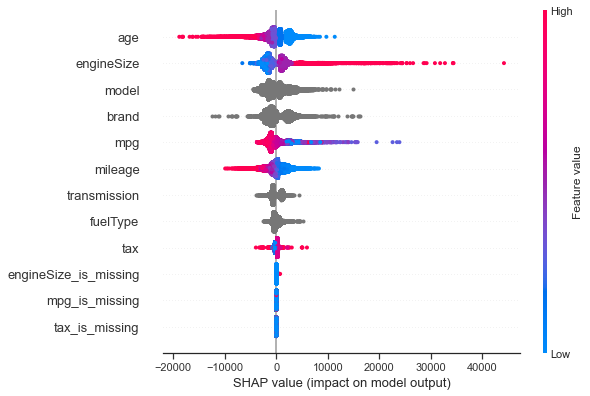

In [51]:
shap.summary_plot(shap_values, features=x_test)

Berdasarkan grafik _beeswarm_ di atas, didapatkan informasi sebagai berikut:   
* Fitur-fitur yang memiliki pengaruh yang moderate hingga tinggi terhadap penentuan `price` (target) secara berurutan adalah `age`, `engineSize`, `mpg`, `mileage`, dan `tax`.
* Semakin besar nilai `age` memiliki pengaruh negatif yang tinggi terhadap nilai `price`. Dengan kata lain semakin tinggi umur suatu mobil maka semakin murah harga mobil tersebut.
* Semakin besar nilai `engineSize` memiliki pengaruh positif yang tinggi terhadap nilai `price`. Dengan kata lain semakin besar kapasitas mesin suatu mobil maka semakin mahal harga mobil tersebut.
* Semakin besar nilai `mpg`, memiliki pengaruh positif yang moderate terhadap nilai `price`. Dengan kata lain semakin irit mobil maka semakin mahal harga mobil tersebut.
* Semakin besar nilai `mileage` memiliki pengaruh negatif yang tinggi terhadap nilai `price`. Dengan kata lain semakin tinggi jumlah jarak yang telah ditempuh mobil maka semakin rendah harga mobil tersebut.
* Semakin besar nilai `tax`, memiliki pengaruh positif yang tinggi terhadap nilai `price`. Dengan kata lain semakin besar nilai pajak mobil maka semakin mahal harga mobil tersebut.

#### Barplot

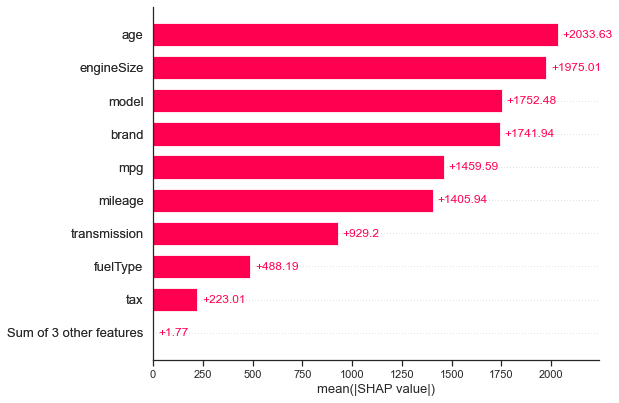

In [52]:
shap.plots.bar(shap_values.abs.mean(0))

>Fitur-fitur yang memiliki _nilai importance_ tertinggi terhadap penentuan `price` (target) secara berurutan adalah `age`, `engineSize`, `model`, `brand`, `mpg`, `mileage`, `transmission`, `fuelType` dan `tax`.

### Contributions of Features (Brand)

In [53]:
xt_indexed=x_test.reset_index()

#### Brand Audi

In [54]:
shap.plots.force(shap_values[11])

In [55]:
shap.plots.force(shap_values[26566])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Audi` memiliki pengaruh yang besar terhadap peningkatan `price` dari suatu mobil.

#### Brand BMW

In [56]:
shap.plots.force(shap_values[5])

In [57]:
shap.plots.force(shap_values[26563])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand BMW` memiliki pengaruh yang besar terhadap peningkatan `price` dari suatu mobil.

#### Brand CClass

In [58]:
shap.plots.force(shap_values[18])

In [59]:
shap.plots.force(shap_values[26556])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Cclass` memiliki pengaruh yang moderate terhadap peningkatan `price` dari suatu mobil.

#### Brand Focus

In [60]:
shap.plots.force(shap_values[37])

In [61]:
shap.plots.force(shap_values[26537])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Focus` memiliki pengaruh yang besar terhadap penurunan `price` dari suatu mobil.

#### Brand Ford

In [62]:
shap.plots.force(shap_values[3])

In [63]:
shap.plots.force(shap_values[26562])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Ford` memiliki pengaruh yang moderate terhadap penurunan `price` dari suatu mobil.

#### Brand Hyundi

In [64]:
shap.plots.force(shap_values[4])

In [65]:
shap.plots.force(shap_values[26535])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Hyundi` memiliki pengaruh yang moderate terhadap penurunan `price` dari suatu mobil.

#### Brand Merc

In [66]:
shap.plots.force(shap_values[9])

In [67]:
shap.plots.force(shap_values[26538])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Merc` memiliki pengaruh yang besar terhadap peningkatan `price` dari suatu mobil.

#### Brand Skoda

In [68]:
shap.plots.force(shap_values[29])

In [69]:
shap.plots.force(shap_values[26551])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Skoda` memiliki pengaruh yang besar terhadap penurunan `price` dari suatu mobil.

#### Brand Toyota

In [70]:
shap.plots.force(shap_values[8])

In [71]:
shap.plots.force(shap_values[26558])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Toyota` memiliki pengaruh yang moderate terhadap penurunan `price` dari suatu mobil.

#### Brand Vauxhall

In [72]:
shap.plots.force(shap_values[0])

In [73]:
shap.plots.force(shap_values[26560])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand Vauxhall` memiliki pengaruh yang besar terhadap penurunan `price` dari suatu mobil.

#### Brand VW

In [74]:
shap.plots.force(shap_values[2])

In [75]:
shap.plots.force(shap_values[26561])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Brand VW` memiliki pengaruh yang kecil terhadap penurunan `price` dari suatu mobil.

### Contributions of Features (Transmission)

#### Transmission Automatic

In [76]:
shap.plots.force(shap_values[27])

In [77]:
shap.plots.force(shap_values[26558])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Transmission Automatic` memiliki pengaruh yang moderate terhadap peningkatan `price` dari suatu mobil.

#### Transmission Manual

In [78]:
shap.plots.force(shap_values[4])

In [79]:
shap.plots.force(shap_values[26557])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Transmission Manual` memiliki pengaruh yang moderate terhadap penurunan `price` dari suatu mobil.

#### Transmission Semi-Auto

In [80]:
shap.plots.force(shap_values[15])

In [81]:
shap.plots.force(shap_values[26544])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Transmission Semi-Auto` memiliki pengaruh yang moderate terhadap peningkatan `price` dari suatu mobil.

#### Transmission Other

In [96]:
shap.plots.force(shap_values[20626])

In [82]:
shap.plots.force(shap_values[22044])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `Transmission Other` memiliki pengaruh yang kecil terhadap penurunan `price` dari suatu mobil.

### Contributions of Features (FuelType)

#### FuelType Diesel

In [84]:
shap.plots.force(shap_values[26555])

In [85]:
shap.plots.force(shap_values[7])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `FuelType Diesel` memiliki pengaruh yang moderate terhadap peningkatan `price` dari suatu mobil.

#### FuelType Electric

In [86]:
shap.plots.force(shap_values[7412])

In [87]:
shap.plots.force(shap_values[9450])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `FuelType Electric` memiliki pengaruh yang besar terhadap peningkatan `price` dari suatu mobil.

#### FuelType Hybrid

In [88]:
shap.plots.force(shap_values[50])

In [89]:
shap.plots.force(shap_values[26558])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `FuelType Hybrid` memiliki pengaruh yang moderate terhadap peningkatan `price` dari suatu mobil.

#### FuelType Petrol

In [90]:
shap.plots.force(shap_values[1])

In [91]:
shap.plots.force(shap_values[26559])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `FuelType Petrol` memiliki pengaruh yang kecil terhadap penurunan `price` dari suatu mobil.

#### FuelType Other

In [92]:
shap.plots.force(shap_values[1745])

In [93]:
shap.plots.force(shap_values[25937])

>Berdasarkan _forceplot_ di atas, dapat dikatakan bahwa `FuelType Other` memiliki pengaruh yang moderate terhadap peningkatan `price` dari suatu mobil.

# Conclusion & Recommendation

## Kesimpulan

1. Setelah dilakukan _model improvement_ dengan menggunakan _Categorical Features_, didapatkan peningkatan MAE Score dari nilai Benchmark **1446.919** menjadi **1416.571**. 

2. Setelah dilakukan _model improvement_ dengan menggunakan _Hyperopt_, didapatkan peningkatan MAE Score dari **1416.571** menjadi **1182.588**, dimana parameter yang ditentukan oleh _Hyperopt_ memiliki performa yang lebih baik dibandingkan parameter yang ditentukan secara default.

3. Setelah dilakukan validasi pada data test dengan menggunakan paramater terbaik, didapatkan peningkatan MAE Score dari **1447.862** (dengan menggunakan model benchmark) menjadi **1164.337** (best model).

4. Fitur-fitur yang memiliki _nilai importance_ yang paling tinggi terhadap penentuan `price` (target) secara berurutan adalah `age`, `engineSize`, `model`, `brand`, `mpg`, `mileage`, `transmission`, `fuelType` dan `tax`.
    * Semakin tinggi nilai `age`,  maka nilai `price` mobil akan semakin rendah.
    * Semakin tinggi nilai `engineSize`,  maka nilai `price` mobil akan semakin tinggi.
    * `Model` suatu mobil akan memengaruhi nilai `price` dari mobil.
    * `Brand` suatu mobil akan memengaruhi nilai `price` dari mobil.
    * Semakin tinggi nilai `mpg`,  maka nilai `price` mobil akan semakin tinggi.
    * Semakin tinggi nilai `mileage`,  maka nilai `price` mobil akan semakin rendah.
    * `Transmission` suatu mobil akan memengaruhi nilai `price` dari mobil.
    * `fuelType` suatu mobil akan memengaruhi nilai `price` dari mobil.
    * Semakin tinggi nilai `tax`,  maka nilai `price` mobil akan semakin tinggi.

## Rekomendasi

POV : (1) Sebagai `calon pembeli` mobil, jika ingin mencari `mobil dengan harga yang rendah` :

> Cari mobil dengan umur mobil (`age`) yang cenderung sudah tua, mobil dengan total jarak tempuh (`mileage`) yang cenderung sudah tinggi, lebih baik mobil dengan tipe `transmission` manual, dan dari `brand` Focus, Ford, Hyundi, Skoda, Toyota, atau Vauxhall.

POV : (2) Sebagai `calon penjual` mobil, jika ingin menjual `mobil dengan harga yang tinggi` :

> Syaratnya adalah mobil dengan umur mobil (`age`) yang cenderung masih muda, mobil dengan total jarak tempuh (`mileage`) yang cenderung masih rendah, mobil dengan jenis bahan bakar (`fuelType`) Electric atau Hybrid, mobil dengan tipe `transmission` Automatic atau Semi-Auto, dan dari `brand` Audi, BMW, CClass, atau Merc.

POV : (3) Sebagai `calon pembeli` mobil dengan kriteria khusus (misal `Brand Merc`), jika ingin membelinya dengan `harga yang rendah` :

> Cari mobil Merc yang umur mobilnya (`age`) yang cenderung sudah tua, total jarak tempuhnya (`mileage`) cenderung sudah tinggi, dan tipe `transmission`nya manual.

POV : (4) Sebagai `calon pembeli` mobil dengan kriteria khusus (misal `fuelType Diesel`), jika ingin membelinya dengan `harga yang rendah` :

> Cari mobil yang umur mobilnya (`age`) yang cenderung sudah tua, total jarak tempuhnya (`mileage`) cenderung sudah tinggi, tipe `transmission`nya manual, dan `brand Ford` menjadi salah satu opsi yang masuk kriteria.